In [1]:
# subm18: blended with subm16
# added directional filters and cumsum,
# input has 4 channels.

import os
import tensorflow as tf
os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
np.random.seed(1)
tf.set_random_seed(1)

import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout2D, Activation
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, array_to_img, img_to_array, load_img
        
PATH = 'input'

sample_df = pd.read_csv('input/sample_submission.csv')
test_ids = sample_df.id.values

Using TensorFlow backend.


In [2]:
#prepare staging directory
EXP_NAME = 'exp18'
TMP_DIR = 'tmp'
STAGE_DIR = os.path.join(TMP_DIR, EXP_NAME)

if not os.path.exists(STAGE_DIR):
    os.makedirs(STAGE_DIR, exist_ok=True)

In [3]:
from sklearn.model_selection import KFold

FOLDS_CSV = os.path.join(PATH, 'folds.csv')
def generate_folds():
    n_fold = 5
    depths = pd.read_csv(os.path.join(PATH, 'depths.csv'))
    depths.sort_values('z', inplace=True)
    depths.drop('z', axis=1, inplace=True)
    depths['fold'] = (list(range(n_fold))*depths.shape[0])[:depths.shape[0]]
    print(depths.head())
    depths.to_csv(FOLDS_CSV, index=False)

if not os.path.exists(FOLDS_CSV):
    generate_folds()


In [4]:
im_width = 128
im_height = 128
im_chan = 4
n_features = 2

In [5]:
#X_train = np.load('input/X_train_128.npy')
#y_train = np.load('input/y_train_128.npy')
#X_test = np.load('input/X_test_128.npy')

X_train_z = np.load('input/X_train_z.npy')
X_test_z = np.load('input/X_test_z.npy')

X_train3 = np.load('data/subm007/X_train3_stage1oof.npy')
X_test3  = np.load('data/subm007/X_test3_stage1oof.npy')

X_train = np.load('input/X_train_filters.npy')
y_train = np.load('input/y_train_filters.npy')
X_test = np.load('input/X_test_filters.npy')


In [6]:
X_train_amount = np.log1p([np.sum(x) for x in X_train3])/10.
X_test_amount = np.log1p([np.sum(x) for x in X_test3])/10.

In [7]:
def load_fold(X_train, X_extra, y_train, fold):
    train_df = pd.read_csv(os.path.join(PATH, 'train.csv'))
    train_ids = train_df.id.values
    
    folds = pd.read_csv(FOLDS_CSV)
    fold_dict = folds.set_index('id').to_dict()['fold']
    
    fold_train = [fold_dict[x]!=fold for x in train_ids]
    fold_val = [fold_dict[x]==fold for x in train_ids]
    
    X_fold, X_fold2, y_fold = X_train[fold_train], X_extra[fold_train], y_train[fold_train]        
    X_val, X_val2, y_val = X_train[fold_val], X_extra[fold_val], y_train[fold_val]    
    return X_fold, X_fold2, y_fold, X_val, X_val2, y_val



In [8]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [9]:
def run_fold(model, X_fold, X_fold2, y_fold, X_val, X_val2, y_val, weights_file, augment=True):
    batch_size = 32
    steps_per_epoch=len(X_fold)//batch_size
    
    if model is None:
        model = build_unet2()
        
    callbacks = [
        #CyclicLR(base_lr=0.001, max_lr=0.006, step_size=5 * steps_per_epoch)
        EarlyStopping(patience=20, verbose=1),
        ReduceLROnPlateau(min_lr=1e-6, patience=5, verbose=1),
        ModelCheckpoint(weights_file, verbose=1, save_best_only=True)
    ]
        
    if augment:
        data_gen_args = dict(
            width_shift_range=0.25,
            height_shift_range=0.25,
            fill_mode='reflect',
            horizontal_flip=True,        
            zoom_range=0.05
        )
    else:
        data_gen_args = {}
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
        
    seed = 1
    image_datagen.fit(X_fold, augment=True, seed=seed)
    mask_datagen.fit(y_fold, augment=True, seed=seed)

    # https://raw.githubusercontent.com/keras-team/keras-preprocessing/master/keras_preprocessing/image.py
    image_generator = image_datagen.flow((X_fold, X_fold2), batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(y_fold, batch_size=batch_size, seed=seed)        
    
    def my_gen(g1, g2):
        while True:
            a = next(g1)
            b = next(g2)
            yield ({'input_image': a[0], 'input_extra': a[1]}, b)
         
    g = my_gen(image_generator, mask_generator)
                    
    results = model.fit_generator(
        g, 
        epochs=150, 
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        validation_data=(({'input_image': X_val, 'input_extra': X_val2}), y_val))

    return model

In [10]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    if np.sum(labels) == 0:
        
        if np.sum(y_pred) > 0:
            return 0
    
        if np.sum(y_pred) == 0:
            return 1

    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)


In [13]:
import uuid

scores_fname = os.path.join(STAGE_DIR, 'scores.csv')
if os.path.exists(scores_fname):
    scores = pd.read_csv(scores_fname).values.tolist()
else:
    scores = []
    scores_df = pd.DataFrame(scores, columns=['fold', 'id', 'val_loss', 'val_iou'])
    scores_df.to_csv(scores_fname, index=False)
    
for fold in []: # range(4, 5):
    id_ = uuid.uuid4().hex    
    
    print('running fold={} id={}'.format(fold, id_))
        
    X_train_extra = np.hstack([X_train_z.reshape(-1, 1), X_train_amount.reshape(-1, 1)])    
    X_fold, X_fold2, y_fold, X_val, X_val2, y_val = load_fold(X_train, X_train_extra, y_train, fold)
    weights_file = os.path.join(STAGE_DIR, "model-tgs-salt-fold{}-id{}.h5".format(fold, id_))
    
    model = run_fold(None, X_fold, X_fold2, y_fold, X_val, X_val2, y_val, weights_file)        
    # model = build_unet2()
    model.load_weights(weights_file)
    model.save(os.path.join(STAGE_DIR, "model-fold{}-id{}.h5".format(fold, id_)))
    val_loss = model.evaluate({'input_image': X_val, 'input_extra': X_val2}, y_val)
    print('val loss: ', val_loss)
        
    # predict eval ds with tta
    val_preds1 = model.predict({'input_image': X_val, 'input_extra': X_val2}, verbose=1)
    val_preds3 = model.predict({'input_image': X_val[:, :, ::-1, :], 'input_extra': X_val2}, verbose=1) # hflip
    val_preds = val_preds1 * val_preds3[:, :, ::-1]
    
    # predict test ds with tta
    X_test_extra = np.hstack([X_test_z.reshape(-1, 1), X_test_amount.reshape(-1, 1)])
    test_preds1 = model.predict({'input_image': X_test, 'input_extra': X_test_extra}, verbose=1)
    test_preds3 = model.predict({'input_image': X_test[:, :, ::-1, :], 'input_extra': X_test_extra}, verbose=1) # hflip
    test_preds = test_preds1 * test_preds3[:, :, ::-1]    

    # find best threshold for non-tta
    #thres = np.linspace(0.3, 0.9, 20)
    #thres_ioc = [iou_metric_batch(y_val, np.int32(val_preds1 > t)) for t in thres]
    #best_thres = thres[np.argmax(thres_ioc)]
    #print('without tta :', best_thres, max(thres_ioc))

    #plt.figure()
    #plt.plot(thres, thres_ioc);
    
    # find best threshold for tta
    thres = np.linspace(0.0, 0.9, 20)
    thres_ioc = [iou_metric_batch(y_val, np.int32(val_preds > t)) for t in thres]
    best_thres_tta = thres[np.argmax(thres_ioc)]
    print('with tta: ', best_thres_tta, max(thres_ioc))
    
    plt.figure()
    plt.plot(thres, thres_ioc);
    
    scores.append([fold, id_, "{:.4f}".format(val_loss), "{:.4f}".format(max(thres_ioc))])
    np.save(os.path.join(STAGE_DIR, "preds_fold{}_{}".format(fold, id_)), test_preds > best_thres_tta)
    np.save(os.path.join(STAGE_DIR, "val_preds_fold{}_{}".format(fold, id_)), val_preds > best_thres_tta)
    
    scores_df = pd.DataFrame(scores, columns=['fold', 'id', 'val_loss', 'val_iou'])
    scores_df.to_csv(scores_fname, index=False)


In [ ]:
#run_fold(None, X_fold, X_fold2, y_fold, X_val, X_val2, y_val, weights_file)        

In [31]:

files = []
for filename in [
    'data/subm016/exp15/preds_fold0_aef7e4ae1d4346b7b4d36de7279147bf.npy', #8198
    'data/subm016/exp15/preds_fold0_3b355ec3463b41d6a2df01833dc457ba.npy', #8016
    'data/subm016/exp15/preds_fold1_a0b720b154594954a2b9ca640ca8a0b5.npy', #7904
    'data/subm016/exp15/preds_fold1_65b4fe0eafff438ea21ed8e9066c7672.npy', #7805
    'data/subm016/exp15/preds_fold2_1282bb60fdae40048210d7a65c05ef7b.npy', #8181
    'data/subm016/exp15/preds_fold2_91cd520ff2aa4d63954262afa7c6c5b1.npy', #8120
    'data/subm016/exp15/preds_fold3_9fc681cee24c4088b3dc9c57cfea89bb.npy', #7942
    'data/subm016/exp15/preds_fold3_e80fcc2f83e94153841aa0a6429003ff.npy', #7839
    'data/subm016/exp15/preds_fold4_4b38c875baec4eddaf297cfcaf421409.npy', #7973
    'data/subm016/exp15/preds_fold4_cf58b2308b9942b1b6bf0c7679c360a8.npy', #7839
    'tmp/exp18/preds_fold0_86ad0dfafe42448d9fa183668eec3f08.npy', #8126
    'tmp/exp18/preds_fold0_6b3dfc4e846c4c5892cc054957979fd9.npy', #7983
    'tmp/exp18/preds_fold1_100102dd16b8495b92198a5ef3c60f15.npy', #7883
    'tmp/exp18/preds_fold1_4ab31dd463864a2fa3e0029665ea6fcb.npy', #7852
    'tmp/exp18/preds_fold2_31493d3d89214adfa06ca08742e51951.npy', #8100
    'tmp/exp18/preds_fold2_a0abddb3d04447a6a8f6440c4a32ecb9.npy', #7949
    'tmp/exp18/preds_fold3_f065d7fba1e8491f8eae142733105972.npy', #7799
    #'tmp/exp18/preds_fold3_',
    'tmp/exp18/preds_fold4_eb59140b87d0478e929f21d61c706377.npy', #7897
    'tmp/exp18/preds_fold4_52ce9353f667457789810c51d82af450.npy', #7987
]:
    files.append(filename)

import numpy as np

preds = np.zeros_like(X_test[..., :1])
for f in files:
    print('loading ', f)
    p = np.load(f)
    preds += p
preds /= len(files)

preds_ = []
for i in tqdm(range(len(preds))):
    preds_.append(resize(np.squeeze(preds[i]), (101, 101), mode='constant', preserve_range=True))
    
    
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


rows = []
for image_id, p in zip(test_ids, preds_):
    mask = rle_encode(np.round(p).T)
    rows.append([image_id, mask])
    
sub = pd.DataFrame(rows, columns=['id', 'rle_mask'])
sub.to_csv('submissions/subm_018.csv', index=False)

loading  data/subm016/exp15/preds_fold0_aef7e4ae1d4346b7b4d36de7279147bf.npy
loading  data/subm016/exp15/preds_fold0_3b355ec3463b41d6a2df01833dc457ba.npy
loading  data/subm016/exp15/preds_fold1_a0b720b154594954a2b9ca640ca8a0b5.npy
loading  data/subm016/exp15/preds_fold1_65b4fe0eafff438ea21ed8e9066c7672.npy
loading  data/subm016/exp15/preds_fold2_1282bb60fdae40048210d7a65c05ef7b.npy
loading  data/subm016/exp15/preds_fold2_91cd520ff2aa4d63954262afa7c6c5b1.npy
loading  data/subm016/exp15/preds_fold3_9fc681cee24c4088b3dc9c57cfea89bb.npy
loading  data/subm016/exp15/preds_fold3_e80fcc2f83e94153841aa0a6429003ff.npy
loading  data/subm016/exp15/preds_fold4_4b38c875baec4eddaf297cfcaf421409.npy
loading  data/subm016/exp15/preds_fold4_cf58b2308b9942b1b6bf0c7679c360a8.npy
loading  tmp/exp18/preds_fold0_86ad0dfafe42448d9fa183668eec3f08.npy
loading  tmp/exp18/preds_fold0_6b3dfc4e846c4c5892cc054957979fd9.npy
loading  tmp/exp18/preds_fold1_100102dd16b8495b92198a5ef3c60f15.npy
loading  tmp/exp18/preds_f

  0%|          | 0/18000 [00:00<?, ?it/s]/opt/miniconda2/envs/avito/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 18000/18000 [00:15<00:00, 1190.26it/s]


In [26]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 

In [27]:

rows = []
for image_id, p in zip(test_ids, preds_):
    rows.append([image_id, rle_encode(np.round(p).T)])
    
sub = pd.DataFrame(rows, columns=['id', 'rle_mask'])
sub.to_csv('submissions/subm_013.csv', index=False)

In [190]:
import pydensecrf.densecrf as dcrf

def dense_crf(img, output_probs):
    h = output_probs.shape[0]
    w = output_probs.shape[1]

    output_probs = np.expand_dims(output_probs, 0)
    output_probs = np.append(1 - output_probs, output_probs, axis=0)

    d = dcrf.DenseCRF2D(w, h, 2)
    U = -np.log(output_probs)
    U = U.reshape((2, -1))
    U = np.ascontiguousarray(U)
    img = np.ascontiguousarray(img)

    print(type(U), U.dtype, U.shape)
    d.setUnaryEnergy(U.astype(np.float32))

    d.addPairwiseGaussian(sxy=3, compat=3)
    d.addPairwiseBilateral(sxy=3, srgb=20, rgbim=img, compat=10)

    Q = d.inference(10)
    Q = np.argmax(np.array(Q), axis=0).reshape((h, w))

    return Q

evaluating fold  3
790/790 [==============================] - 1s 1ms/step
val loss:  0.10585301160057889
790/790 [==============================] - 1s 1ms/step
with tta:  0.14210526315789473 0.5135443037974684


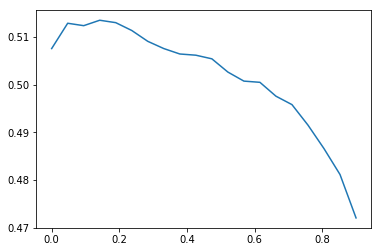

In [163]:
# evaluate from saved checkpoints
id_ = 'f065d7fba1e8491f8eae142733105972'
for fold in [0]: #range(5):
    print('evaluating fold ', fold)
    
    X_train_extra = np.hstack([X_train_z.reshape(-1, 1), X_train_amount.reshape(-1, 1)])    
    X_fold, X_fold2, y_fold, X_val, X_val2, y_val = load_fold(X_train, X_train_extra, y_train, fold)
    weights_file = os.path.join(STAGE_DIR, "model-tgs-salt-fold{}-id{}.h5".format(fold, id_))
    
    #model = build_unet2()
    #model.load_weights(weights_file)
    val_loss = model.evaluate({'input_image': X_val, 'input_extra': X_val2}, y_val)
    print('val loss: ', val_loss)
        
    # predict eval ds with tta
    val_preds1 = model.predict({'input_image': X_val, 'input_extra': X_val2}, verbose=1)
    
    #val_preds_final = np.zeros_like(val_preds1)
    val_preds_final = val_preds1.copy()
    #val_preds_weights = np.ones_like(val_preds1)
    
    def pad_h(x, amount):
        x2 = np.pad(x, ((0, 0), (0, 0), (amount, 0), (0, 0)), mode='reflect')
        x2[:, :, 3:amount+1, :] = x2[:, :, :amount-2, :]
        return x2

    def pad_v(x, amount):
        x2 = np.pad(x, ((0, 0), (amount, 0), (0, 0), (0, 0)), mode='reflect')
        x2[:, 3:amount+1, :, :] = x2[:, :amount-2, :, :]
        return x2

    for hshift in [64]:
        X_val_tta = pad_h(X_val, hshift)
        val_preds_tta = model.predict({'input_image': X_val_tta[:, :, :-hshift, :], 'input_extra': X_val2}, verbose=1)
        val_preds_final[:, :, :(128-hshift), :] *= val_preds_tta[:, :, hshift:, :]
        #val_preds_weights[:, :, :(128-hshift), :] += 1
            
    for vshift in [64]:
        X_val_tta = pad_v(X_val, vshift)
        val_preds_tta = model.predict({'input_image': X_val_tta[:, :-vshift, :, :], 'input_extra': X_val2}, verbose=1)
        val_preds_final[:, :(128-vshift), :, :] *= val_preds_tta[:, vshift:, :, :]
        #val_preds_weights[:, :(128-vshift), :, :] += 1

    val_preds3 = model.predict({'input_image': X_val[:, :, ::-1, :], 'input_extra': X_val2}, verbose=1)
    val_preds_final *= val_preds3
    #val_preds_weights += 1

    #val_preds_final /= val_preds_weights
    
    # predict test ds with tta
    #X_test_extra = np.hstack([X_test_z.reshape(-1, 1), X_test_amount.reshape(-1, 1)])
    #test_preds1 = model.predict({'input_image': X_test, 'input_extra': X_test_extra}, verbose=1)
    #test_preds3 = model.predict({'input_image': X_test[:, :, ::-1, :], 'input_extra': X_test_extra}, verbose=1) # hflip
    #test_preds = test_preds1 * test_preds3[:, :, ::-1]    

    if False:
        # find best threshold for non-tta
        thres = np.linspace(0.3, 0.9, 20)
        thres_ioc = [iou_metric_batch(y_val, np.int32(val_preds1 > t)) for t in thres]
        best_thres = thres[np.argmax(thres_ioc)]
        print('without tta :', best_thres, max(thres_ioc))

    if True:
        # find best threshold for tta
        thres = np.linspace(0.0, 0.9, 20)
        thres_ioc = [iou_metric_batch(y_val, np.int32(val_preds_final > t)) for t in thres]
        best_thres_tta = thres[np.argmax(thres_ioc)]
        print('with tta: ', best_thres_tta, max(thres_ioc))

        plt.figure()
        plt.plot(thres, thres_ioc);
    


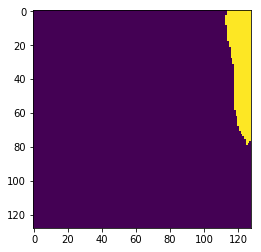

In [196]:
plt.imshow(val_preds1[11, ..., 0]>0.5)

<class 'numpy.ndarray'> float16 (2, 16384)


/opt/miniconda2/envs/avito/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


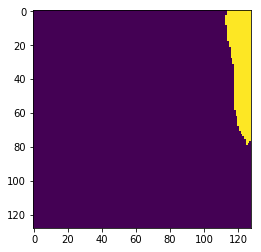

In [195]:
plt.imshow(dense_crf(X_val[11, ..., :3].astype(np.uint8), (val_preds1[11, ..., 0]>0.5).astype(np.uint8)))

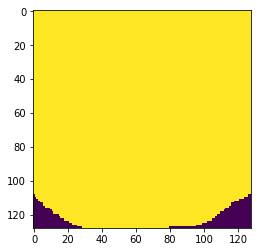

In [160]:
plt.imshow(y_val[8, ..., 0])

In [ ]:
"""
evaluating fold  0
val loss:  0.13396431697003636
without tta : 0.6473684210526316 0.7848148148148149
with tta:  0.14210526315789473 0.7860493827160494

evaluating fold  1
val loss:  0.13235422748312428
without tta : 0.7105263157894738 0.7827114427860696
with tta:  0.28421052631578947 0.7896766169154229

evaluating fold  2
val loss:  0.14500804613866877
without tta : 0.4578947368421053 0.8028360049321825
with tta:  0.37894736842105264 0.8086313193588163

evaluating fold  3
val loss:  0.13725923001766205
without tta : 0.7105263157894738 0.7362025316455697
with tta:  0.4263157894736842 0.7434177215189873

evaluating fold  4
val loss:  0.14418715124676942
without tta : 0.4263157894736842 0.7755414012738853
with tta:  0.28421052631578947 0.7782165605095541


"""

In [80]:
fold=3
_, _, _, X_val, _, y_val = load_fold(X_train, X_train_extra, y_train, fold)
val_pred = np.load('data/subm016/exp15/val_preds_fold3_7395eafcc22e45fc9c4c4401949414d5.npy')
val_scores = []
for a, b in zip(y_val, val_pred):
    val_scores.append(iou_metric(a, np.round(b)))
    

/opt/miniconda2/envs/avito/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: RuntimeWarning: overflow encountered in multiply
  return getattr(obj, method)(*args, **kwds)


In [100]:
df = pd.DataFrame([(idx, np.sum(a), np.sum(b), c) 
                   for idx, (a, b, c) in enumerate(zip(y_train, val_pred, val_scores))], columns=['idx', 'amount_gt', 'amount_predicted', 'score'])

In [113]:
bad_df = df[df.score==0]
#sns.regplot(bad_df.amount_gt, bad_df.amount_predicted)
len(df[(df.amount_predicted==0)&(df.score==0)&(df.amount_gt>0)])

38

In [118]:
# what's the score without false negatives (gt>0 and pred==0)?
df[~((df.amount_predicted==0)&(df.score==0)&(df.amount_gt>0))].score.mean()

0.8271276595744681

In [119]:
# what's the score without false positives (gt ==0 and pred > 0)
df[~((df.amount_predicted>0)&(df.score==0)&(df.amount_gt==0))].score.mean()

0.8077922077922078

In [120]:
fp = df[(df.amount_predicted==0)&(df.score==0)&(df.amount_gt>0)]

/opt/miniconda2/envs/avito/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


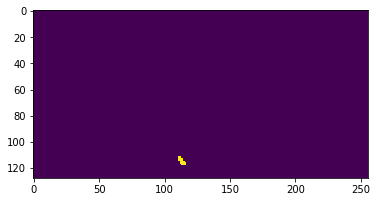

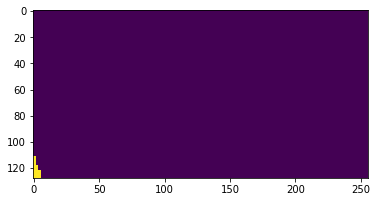

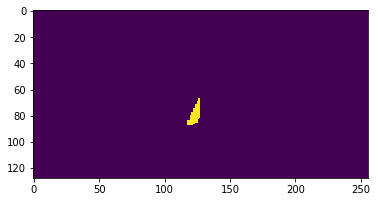

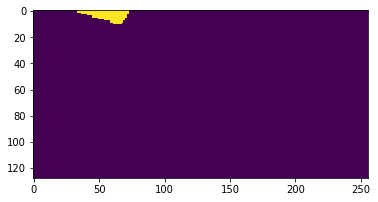

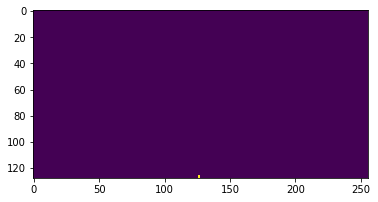

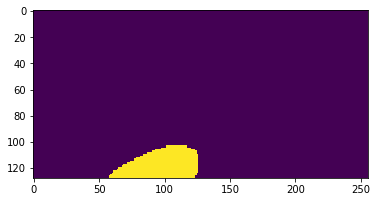

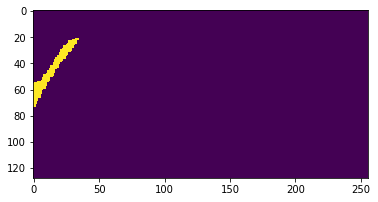

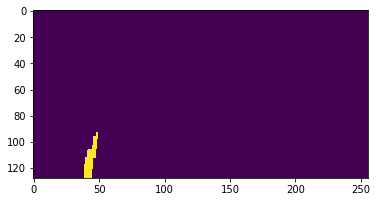

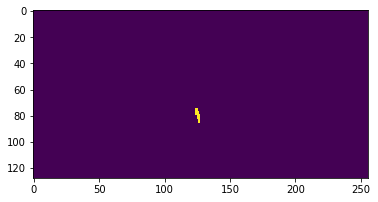

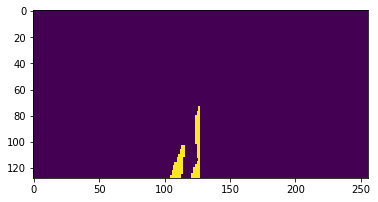

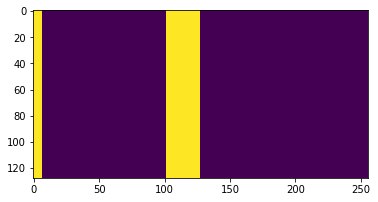

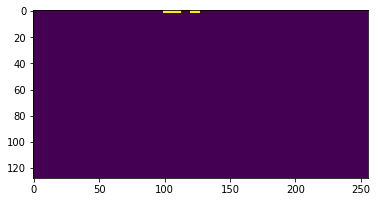

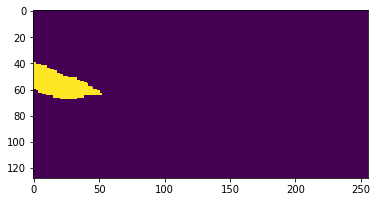

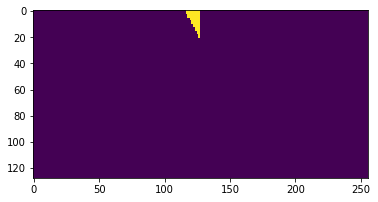

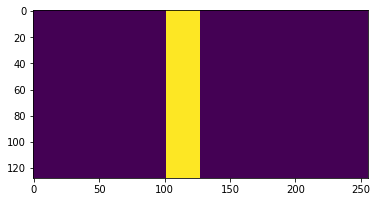

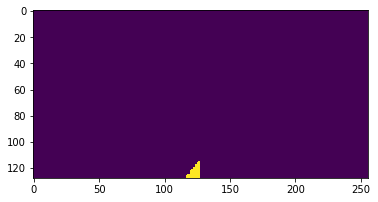

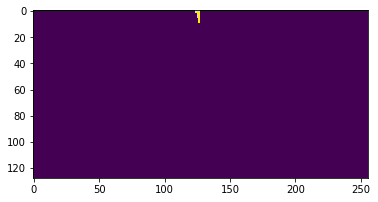

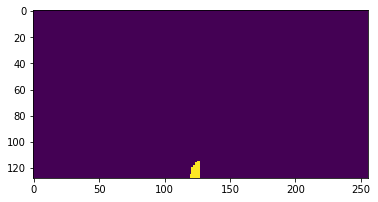

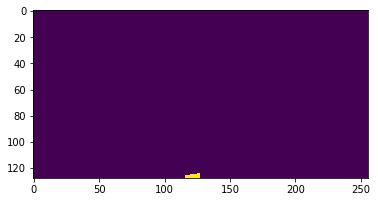

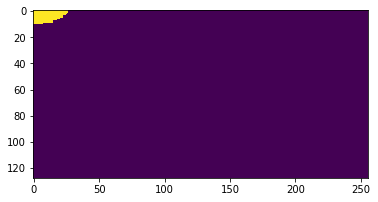

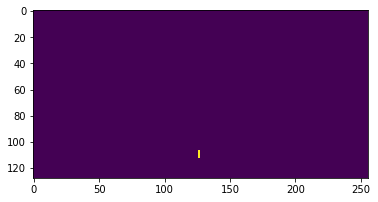

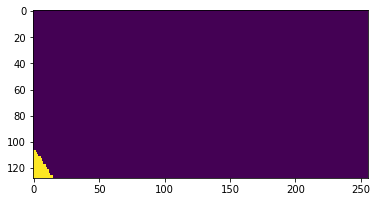

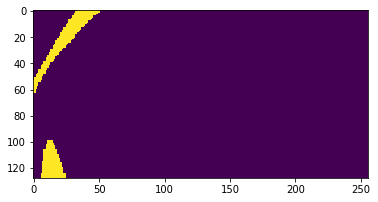

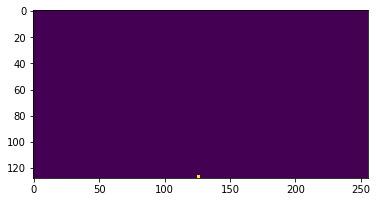

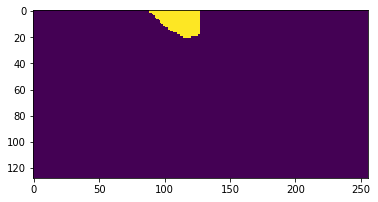

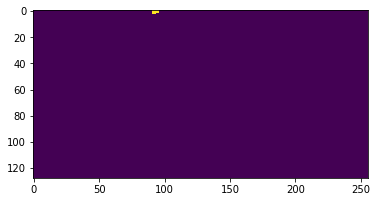

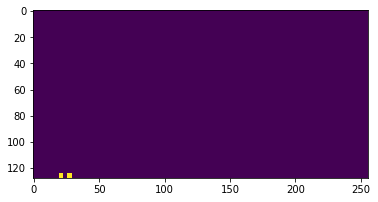

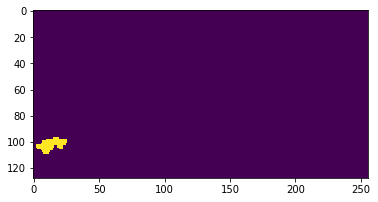

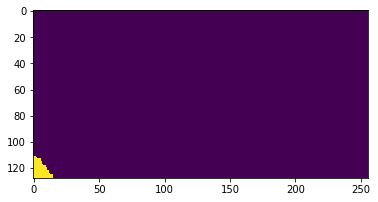

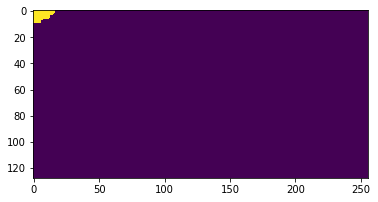

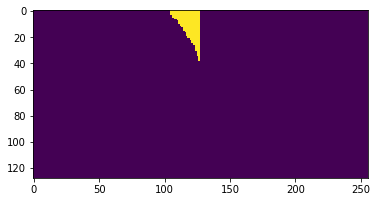

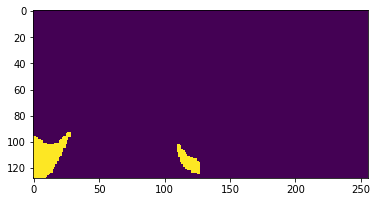

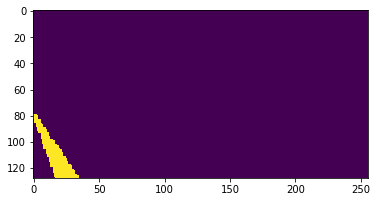

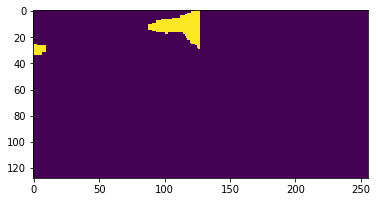

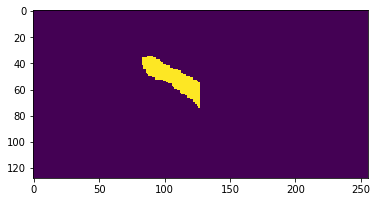

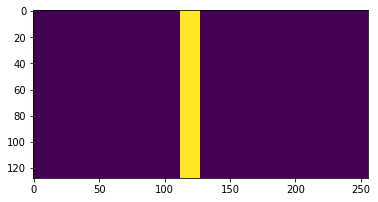

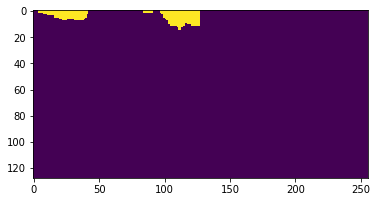

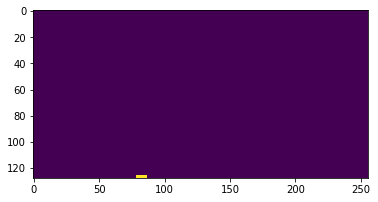

In [130]:
for idx in fp.idx.values:
    plt.figure()
    plt.imshow(np.hstack([y_val[idx, ..., 0], val_pred[idx, ..., 0]]), vmin=0, vmax=1)

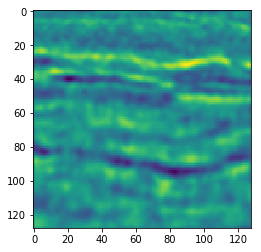

In [25]:
plt.imshow(X_val[0, ..., 0])

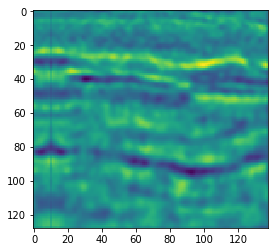

In [44]:
X_val2 = np.pad(X_val, ((0, 0), (0,0), (10, 0), (0,0)), mode='reflect', reflect_type='even')
plt.imshow(X_val2[0, ..., 0])

In [49]:
X_val2[:, :, 3:11, 0] = X_val2[:, :, 0:8, 0]

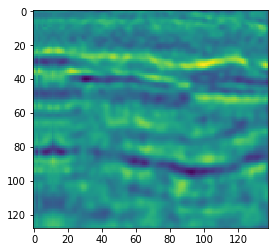

In [50]:
plt.imshow(X_val2[0, ..., 0])

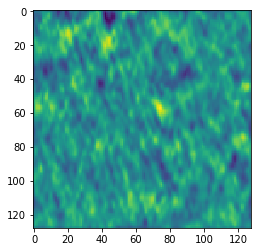

In [89]:
plt.imshow(X_val[1, ..., 0])

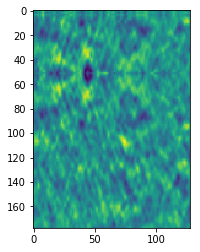

In [90]:
X_val3 = pad_v(X_val, 50)
plt.imshow(X_val3[1, ..., 0])

In [60]:
import numpy as np
import matplotlib.pyplot as plt

fold=0
X_train_extra = np.hstack([X_train_z.reshape(-1, 1), X_train_amount.reshape(-1, 1)])    
_, _, _, X_val, _, y_val = load_fold(X_train, X_train_extra, y_train, fold)

p1 = np.load('data/subm018/exp18/val_preds_fold0_86ad0dfafe42448d9fa183668eec3f08.npy')
p2a = np.load('pytorch/fold0_preds1.npy')
p2b = np.load('pytorch/fold0_preds2.npy')
p2c = np.load('pytorch/fold0_preds.npy')

In [61]:
val_masks = np.load('input/masks.npy')

def load_fold_masks(masks, fold):
    train_df = pd.read_csv(os.path.join(PATH, 'train.csv'))
    train_ids = train_df.id.values
    
    folds = pd.read_csv(FOLDS_CSV)
    fold_dict = folds.set_index('id').to_dict()['fold']
    fold_val = [fold_dict[x]==fold for x in train_ids]
    return masks[fold_val]

fold0_masks = load_fold_masks(val_masks, 0)
#scores = []
#kernel = np.ones((5,5),np.uint8)
#for m, p in zip(fold0_masks, p2):    
#    scores.append(iou_metric(m, p), print_table=False))    

#print(np.mean(scores))

In [59]:
#plt.imshow(p2[11, ..., 0])

y_val.shape, fold0_masks.shape, p2.shape, p1.shape

((810, 128, 128, 1), (810, 101, 101), (810, 101, 101, 1), (810, 128, 128, 1))

iou:  0.5684210526315789 0.7940740740740742


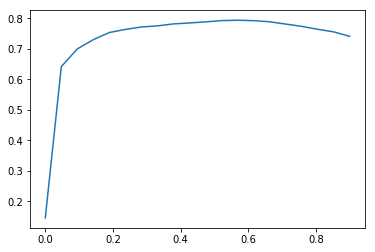

In [62]:
#scores = []
#
#for i in range(fold0_masks.shape[0]):
#    score = iou_metric_batch(fold0_masks[i], (p2[i]>0.5).astype(np.uint8))
#    #score = iou_metric(y_val[i], p2[i]>0.5, print_table=True)
#    scores.append(score)
#print(np.mean(scores))    
    
thres = np.linspace(0.0, 0.9, 20)
thres_ioc = [iou_metric_batch(fold0_masks, np.int32(p2a > t)) for t in thres]
best_thres_tta = thres[np.argmax(thres_ioc)]
print('iou: ', best_thres_tta, max(thres_ioc))

plt.figure()
plt.plot(thres, thres_ioc);
        

iou:  0.28421052631578947 0.8008641975308642


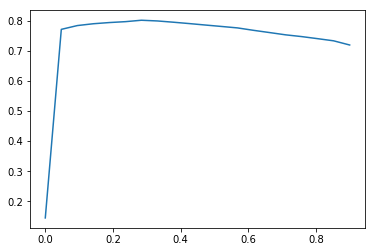

In [64]:
thres = np.linspace(0.0, 0.9, 20)
thres_ioc = [iou_metric_batch(fold0_masks, np.int32(p2 > t)) for t in thres]
best_thres_tta = thres[np.argmax(thres_ioc)]
print('iou: ', best_thres_tta, max(thres_ioc))

plt.figure()
plt.plot(thres, thres_ioc);

/opt/miniconda2/envs/avito/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


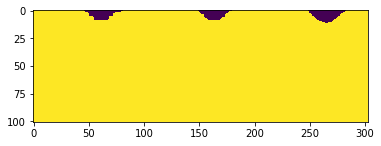

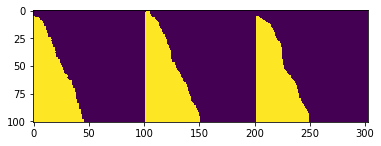

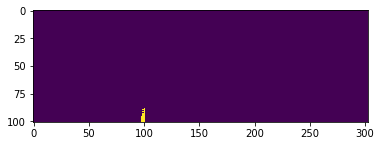

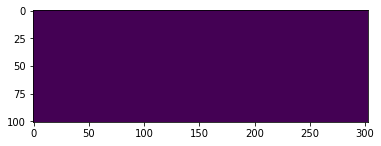

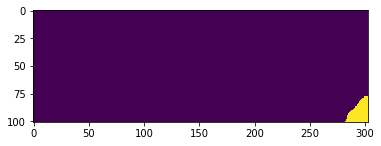

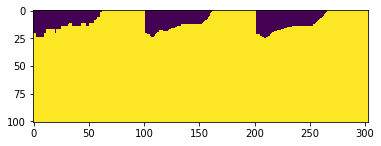

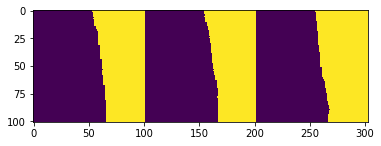

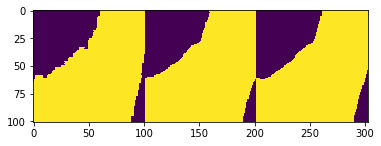

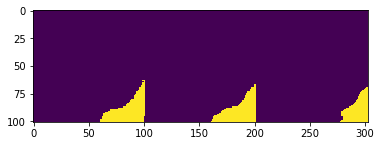

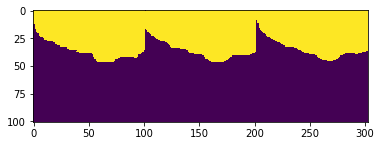

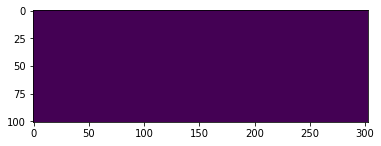

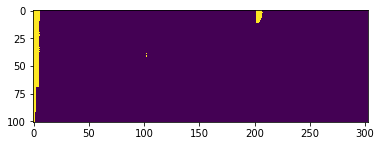

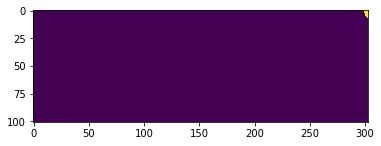

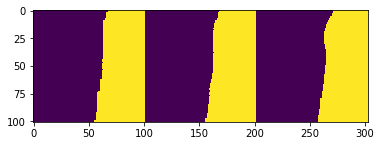

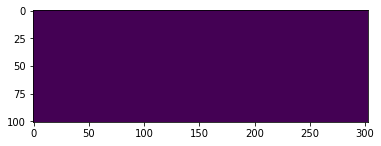

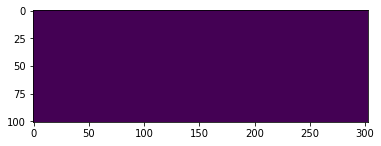

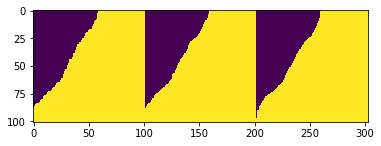

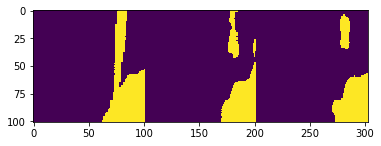

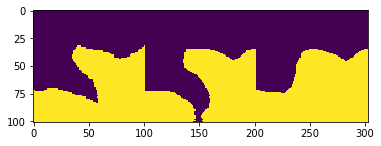

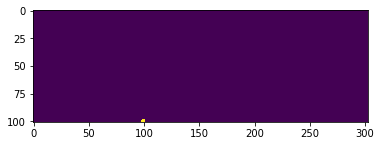

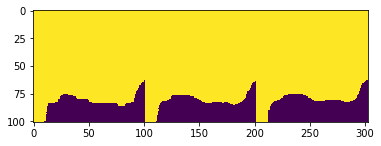

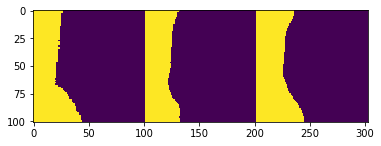

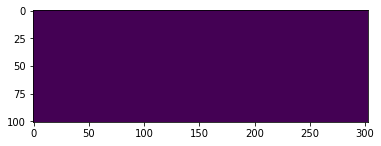

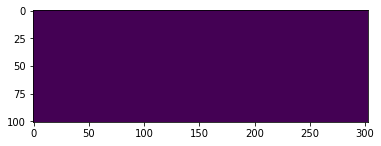

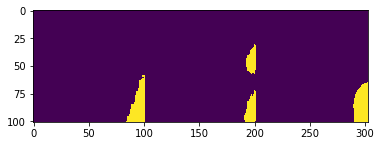

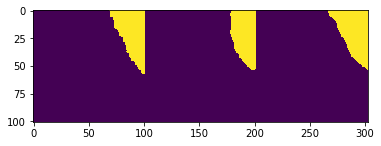

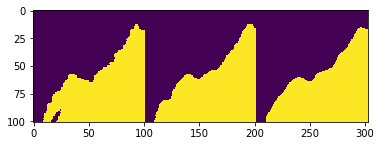

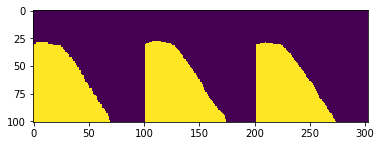

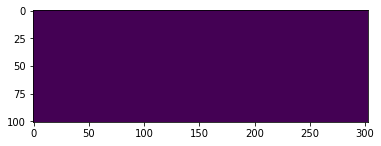

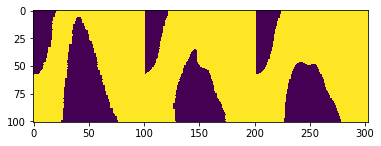

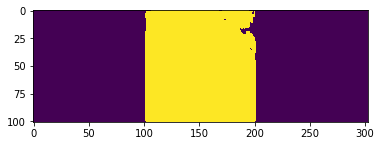

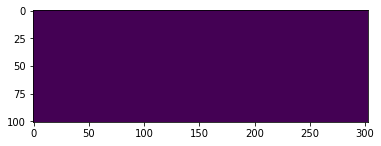

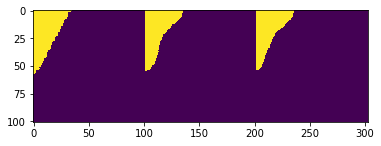

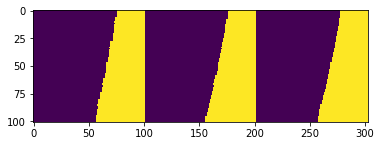

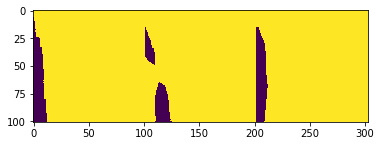

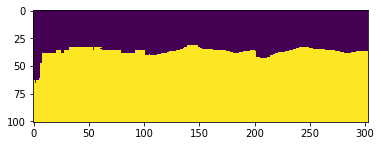

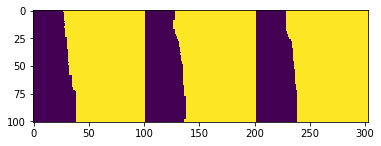

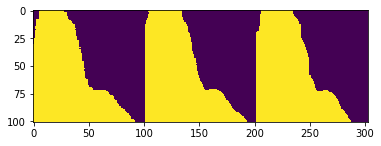

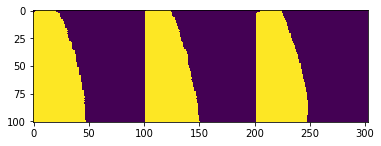

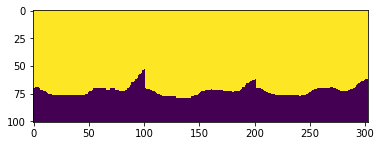

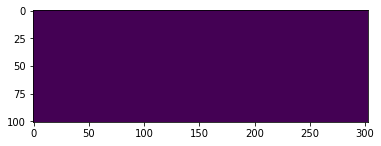

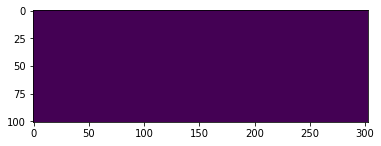

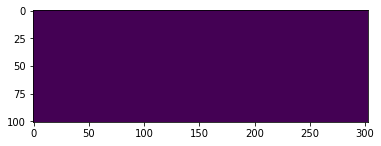

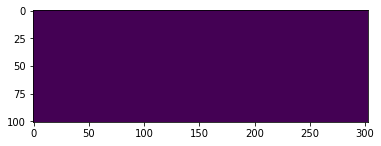

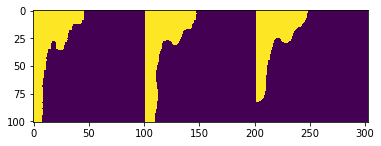

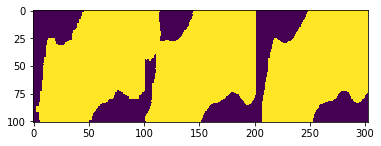

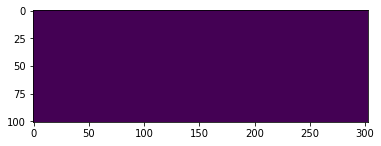

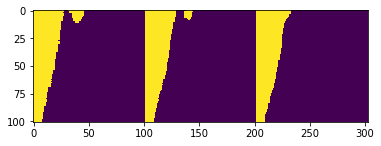

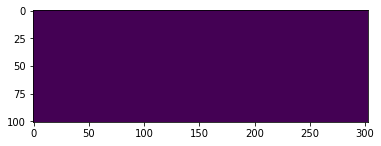

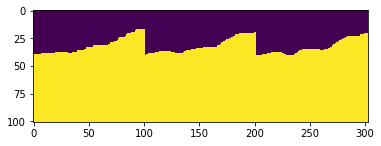

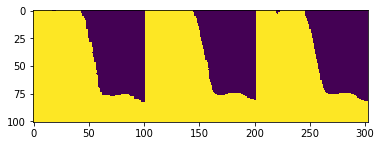

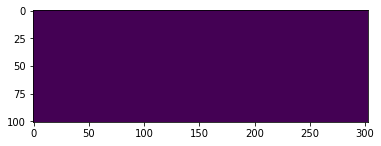

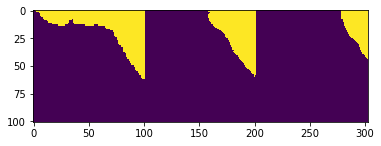

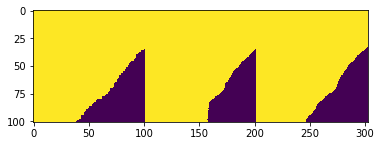

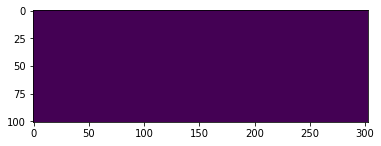

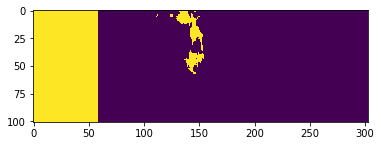

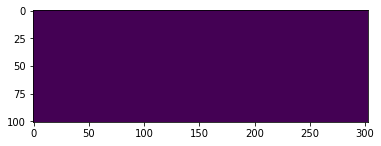

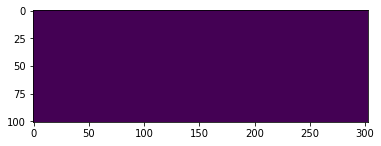

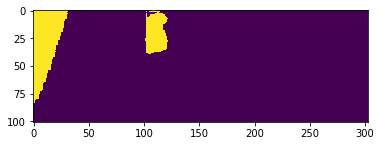

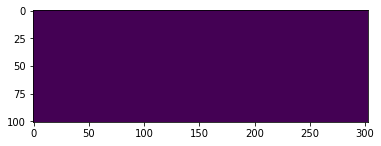

In [56]:
for idx in range(750, 810):
    plt.figure()
    plt.imshow(np.hstack([cv2.resize(y_val[idx, ..., 0].astype(np.uint8), (101, 101)), 
                          cv2.resize((p1[idx, ..., 0]>.99).astype(np.uint8), (101, 101)), 
                          (p2[idx, ..., 0]>0.5).astype(np.uint8)]))


In [25]:
np.max(p2[2, ..., 0])

0

In [23]:
p2.shape

(810, 101, 101, 1)